In [ ]:
pip install  numdifftools

In [ ]:
pip install torchvision 

In [232]:
#import packages
import numpy as np
from sklearn import linear_model
import random
from math import log,sqrt
import matplotlib.pyplot as plt
import numdifftools as nd
import warnings
from scipy.optimize import minimize
import torch
from torch import optim



In [233]:
#Define funcitons that will be useful for algorithms simulations 

def Rademacher_matrix(d,n):
    """
    This fucntion generates a Rademacher matrix
    """
    return np.random.choice([-1, 1], size=(d,n))



def Rademacher_matrix_concatenated(d,n):
    """
    This function generates a Rademacher matrix and add a line of ones
    """
    Z=Rademacher_matrix(d,n)
    Last_line_of_ones = np.ones((1, Z.shape[1]))
    return (Z,np.concatenate((Z, Last_line_of_ones), axis=0))



def Lasso_reg(Y_tilde,Z):
    """
    This function gives the solution to the Lasso regression in a multivariate model
    """
    lasso = linear_model.LassoCV(cv=5)
    lasso.fit(Z,Y_tilde )
    g = lasso.coef_
    u=lasso.intercept_
    return(g,u)



def random_vector_unit_spehre(d):
    random_vector = np.random.normal(size=d)
    return(random_vector/np.linalg.norm(random_vector))



def random_unit_vector_on_S_t(d,S_t):
     """
     This function simulates a unit random vector on the spehre S_t
     """
     u_t=np.zeros(d)
     indices=np.array(S_t)
     u_t[indices]=np.random.normal(size=len(indices))
     return(u_t/np.linalg.norm(u_t))


def psi(x,a=2):
    """ 
    This fonction computes the operator psi(x)= 1/2(a-1)*||x||_{a}^{2}. The choice of a must be such that: 1<a<=2. 
    """
    return ((1/2*(a-1))*(np.linalg.norm(x, ord=a)**2))


def Delta_psi(psi,x,y,a=2):
    """ 
    This function computes the operator Delta_psi(x,y)= psi(y)-psi(x)-<nabla(psi(x)),y-x>.
    This approach is the most general one, since a numerical methode is used to compute the gradient of the function psi.
    """
    gradient_psi= nd.Gradient(psi)(x,a)
    return(psi(y,a)-psi(x,a)-( gradient_psi.T@(y-x)))



def constraint (x,B):
    """ 
    This function defines the constraint that x is within the sphere of radius B . 
    """
    return (np.linalg.norm(x,ord=1) - B)


def miror_descent_objectif_function_general(x,nu,g_t_tilde,x_t,psi,a=2):
    """ 
    This is the function to optimise fro the MD update step. The following function corresponds to the general case. 

    """
    result=nu*g_t_tilde.T@(x-x_t)+Delta_psi(psi=psi,x=x,y=x_t,a=a)
    return(result[0])


def miror_descent_objectif_function_a_2(x,x_t,g_t_tilde,nu=1):
    """ 
    This is the function to optimise fro the MD update step. It corresponds to the particular case where a is equal to 2. 
    """
    result=nu*g_t_tilde.T@(x-x_t)+1/2*(np.linalg.norm(x-x_t)**2)
    return(result[0])



def miror_descent_argmin(objectif_function,B,d,g_t_tilde,x_t,nu=1):
    #eta,g_t_tilde,x_t,constraint,psi,B,a=2
    """
    This function computes the minimum of the function to optimize during the MD update step. 
    """
    x0 = np.random.normal(size=(d,))
    constraints = ({'type': 'ineq', 'fun': lambda x: constraint(x, B)})
    result=minimize(objectif_function, x0,args=(x_t,g_t_tilde,nu) ,constraints=constraints)
    return(result.x)


def optimiser_torch(f,d,nb_it=100,learning_rate=0.1,*args, **kwargs):
     """ 
     This function computes the minimum of a given function using torch methods
     """
     X_t = torch.ones(d, requires_grad=True) # Fix an intial guess. Here we fix the intial guess to be a vector of ones 
     optimizer = torch.optim.Adam([X_t], lr=learning_rate)
     for i in range(nb_it):
        optimizer.zero_grad()
        loss_value = f(X_t,*args, **kwargs)
        loss = torch.tensor(loss_value, dtype=torch.float32, requires_grad=True)
        loss.backward()
        optimizer.step()
     return X_t


def optimiser_scipy(f,d,S,noise=0,methode='trust-constr'):
    """ 
    This function computes the minimum of a given function using scipy methods. 
    to chose the methode you can check this link : https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    """
    initial_guess = np.zeros(d)# Fix an intial guess. Here we fix the intial guess to be a vector of ones
    min = minimize(f, initial_guess,args=(S,noise),method=methode)
    return( min.x)

In [234]:
#This cell is for testing a methode to solve the MD 
def calculate_ratio(x):
    result = np.zeros_like(x)  # Create an array of zeros with the same shape as x

    for i, val in enumerate(x):
        if val != 0:
            result[i] = val / abs(val)
        else:
            result[i] = 0  

    return result



def objective_lagragien(x,x_t,g_t_tilde,eta,nu,B):
    d=x_t.shape[0]
    x_t=x_t.reshape((d, 1))
    x=x.reshape((d, 1))
    x_lamda=calculate_ratio(x)
    lamda=(x_lamda.T)@(eta*g_t_tilde+(x-x_t))/d
    result=miror_descent_objectif_function_a_2(x=x,nu=nu,g_t_tilde=g_t_tilde,x_t=x_t)+lamda*(np.linalg.norm(x, ord=1))-B
    result_scalar=result[0][0]
    return(result_scalar)


def opt_MD(f,d,x_t,g_t_tilde,eta,nu,B,methode='trust-constr'):
    initial_guess = np.zeros(d)# Fix an intial guess. Here we fix the intial guess to be a vector of ones
    min = minimize(f, initial_guess,args=(x_t,g_t_tilde,eta,nu,B),method=methode)
    return( min.x)

In [246]:
def GradiantEstimate(x_t_vect:np.ndarray,d,n,delta,f,S):
    """
    This function corresponds to the pseudo algorithme 1 defined in the paper
    """
    Z=Rademacher_matrix(d,n)
    y_t_vect=np.zeros(n)
    for i in range(n):
        z_i=Z[:, i]
        y_t_vect[i] = f(x_t_vect+delta*z_i,S) #Construct the vector y_t:= f(x_t+delta*z_i)+noise. We suppose that f returns the true output plus noise
    y_tilde=y_t_vect/delta
    (g,u)=Lasso_reg(Y_tilde=y_tilde,Z=Z.T)
    return(g,u)


def debiased_Lasso(x_t_vect:np.ndarray,d,n,delta,f,S):
     """
    This function computes  the debiased lasso
    """

     Z=Rademacher_matrix(d,n)
     y_t_vect=np.zeros(n)
     ones=np.ones(n)
     for i in range(n):
        z_i=Z[:, i]
        y_t_vect[i] = f(x_t_vect+delta*z_i,S) #Construct the vector y_t:= f(x_t+delta*z_i)+noise. We suppose that f returns the true output plus noise
     y_tilde=y_t_vect/delta
     (g,u)=Lasso_reg(Y_tilde=y_tilde,Z=Z.T)
     g_tilde=g+((1/n)*Z@(y_tilde-u*ones))
     d_s=g_tilde.shape[0]
     g_tilde=g_tilde.reshape((d_s, 1))
     return(g_tilde)

    
def BGD(delta,T_prime,f,d,y_t,S_t,S,nu=0.01):
        for t_prime in range (T_prime):
             u_t=random_unit_vector_on_S_t(d=d,S_t=S_t) # select the unit vector u_t uniformly at random
             x_t=y_t+delta*u_t #update x_t at each step where x_t=y_t+delta*u_t.
             c_t=(f(x_t+delta*u_t,S)-f(x_t+delta*u_t,S))/(2*delta)
             y_t=y_t-(nu*c_t*len(S_t)*u_t)
        return y_t




def Successive_selection_algo(T,eta,delta,f,s,d,S,f_star=0,x_star=0,nu=1):
    """ 
    This function computes the Successive selection algorithm. 
    The function will return empty lists if it's impossible to compute the algorithme
    Parameters:
    ----------
    T: is the budget.
    Eta: the threshold value
    Delta:A parameter to compute the neighborhood of the f(x_t)
    s: is the sparsity level
    f: is the black-box function to optimize
    f_star is the true minimum of f. It is used in this function just for testing perspectives.
    x_star is the true argmin of f. It is used in this function just for testing perspectives.

    """
    x_t_vect=np.zeros(d)
    S_hat_t=[]
    S_hat_t_minus_1=[1]
    #chi_tilde={x for x in chi if np.linalg.norm(x,ord=1)<=B}
    T_prime=int(T/2)
    simple_regret=[]
    cumulative_regret=[]
    t=0
    x_t_cost=[]
    while   t<s and S_hat_t!=S_hat_t_minus_1  : # setting  conditions to stop the while loop  len(S_hat_t)<s
        
        t=t+1
        g_hat_t,u_t=GradiantEstimate(x_t_vect=x_t_vect,d=d,delta=delta,f=f,S=S,n=T_prime) # Estimate the gradient g_t 
        right_set=[i for i in range(d) if abs(g_hat_t[i]) >= eta]
        S_hat_t_minus_1=S_hat_t.copy() # update S_hat_minus_1
        S_hat_t=S_hat_t_minus_1 + (right_set) # Thresholding
        S_hat_t=list(set(S_hat_t)) #To remove duplicates from S_hat_t
        if len(S_hat_t)==0:
             break
        else:
            x_t_minus_one=x_t_vect.copy() # Keep a copy of x_t to use it for the output 
            x_t_vect=BGD(T_prime=T_prime,f=f,d=d,y_t=x_t_vect,S_t=S_hat_t,delta=delta,S=S,nu=nu) # performe the finite difference algorithme that returns x_t
            simple_regret.append(f(x_t_vect,S,noise=0)-f_star)
            cumulative_regret.append(((sum(cumulative_regret)+f(x_t_vect,S,noise=0))/(len(cumulative_regret)+1))-f_star)
            x_t_cost.append(np.linalg.norm(x_star-x_t_vect))
        

    if len(S_hat_t)==s:
         return(x_t_vect,simple_regret,cumulative_regret,x_t_cost)
    elif len(S_hat_t)==0: 
         warnings.warn("Algorithm did not make any discovery",stacklevel=2)
         return([],[],[],[])

         
    else:
         return(x_t_minus_one,simple_regret,cumulative_regret,x_t_cost)
    


def First_order_optimization(B,T,n,d,psi,eta,delta,S,f,objectif_function,constraint,f_star=0,x_star=0,nu=1):
     """
    This function computes the First-order mirror descent with estimated gradients. 
    The function will return empty lists if it is suspected that the algorithm will diverge. 
    You should then change the hyperparameters.


    Parameters:
    ----------
    T: is the budget.
    Eta: the hyperpameter for the MD update
    Delta:A parameter to compute the neighborhood of the f(x_t)
    s: is the sparsity level
    f: is the black-box function to optimize
    f_star is the true minimum of f. It is used in this function just for testing perspectives.
    x_star is the true argmin of f. It is used in this function just for testing perspectives.
    Constraint: is such that x belongs to the sphere of radius B. 
    This will be removed when this code is put into a class.

     """
     x_t_vect=np.zeros(d)
     T_prime=int(T/2)
     simple_regret=[]
     cumulative_regret=[]
     cost=[]
     for t in range(T_prime):
          g_t_tide=debiased_Lasso(x_t_vect=x_t_vect,d=d,n=n,delta=delta,f=f,S=S)
          x_t_vect=miror_descent_argmin(objectif_function=objectif_function,B=B,d=d,g_t_tilde=g_t_tide,x_t=x_t_vect,nu=nu)
          simple_regret.append(f(x_t_vect,S,noise=0)-f_star)
          cumulative_regret.append(((sum(cumulative_regret)+f(x_t_vect,S,noise=0))/(len(cumulative_regret)+1))-f_star)
          cost.append(np.linalg.norm(x_star-x_t_vect)) 
          if len(cost)>1:
           if cost[-1]-cost[-2]>1e3:
               warnings.warn("The algorithm has started diverging, and the computation will be stopped.",stacklevel=2)
               break
     return(x_t_vect,simple_regret,cumulative_regret,cost)

def First_order_optimization_modified(B,T,n,d,eta,delta,S,f,objectif_function,f_star=0,x_star=0):
     """
    This function computes the First-order mirror descent with estimated gradients. 
    The function will return empty lists if it is suspected that the algorithm will diverge. 
    You should then change the hyperparameters.


    Parameters:
    ----------
    T: is the budget.
    Eta: the hyperpameter for the MD update
    Delta:A parameter to compute the neighborhood of the f(x_t)
    s: is the sparsity level
    f: is the black-box function to optimize
    f_star is the true minimum of f. It is used in this function just for testing perspectives.
    x_star is the true argmin of f. It is used in this function just for testing perspectives.
    Constraint: is such that x belongs to the sphere of radius B. 
    This will be removed when this code is put into a class.

     """
     x_t_vect=np.zeros(d)
     T_prime=int(T/2)
     simple_regret=[]
     cumulative_regret=[]
     cost=[]
     for t in range(T_prime):
          g_t_tide=debiased_Lasso(x_t_vect=x_t_vect,d=d,n=n,delta=delta,f=f,S=S)
          x_t_vect=opt_MD(f=objectif_function,d=d,x_t=x_t,g_t_tilde=g_t_tide,eta=eta,nu=1,B=B)
          simple_regret.append(f(x_t_vect,S,noise=0)-f_star)
          cumulative_regret.append(((sum(cumulative_regret)+f(x_t_vect,S,noise=0))/(len(cumulative_regret)+1))-f_star)
          cost.append(np.linalg.norm(x_star-x_t_vect)) 
          if len(cost)>1:
           if cost[-1]-cost[-2]>1e3:
               warnings.warn("The algorithm has started diverging, and the computation will be stopped.",stacklevel=2)
               break
     return(x_t_vect,simple_regret,cumulative_regret,cost)




          

    


In [247]:
# Functions that will be used for testing 
def f_test(x_t,noise=0):#S le support 
    return(np.linalg.norm(x_t)**2+noise*np.random.normal(0,1,1))



def vect_f_test(x_t, delta, d, n):
    y_t_vecteur = np.zeros(n)
    for i in range(n):
        y_t_vecteur[i] = f_test(x_t, delta, d)
    y_t = f_test(x_t=x_t, delta=0, d=d, noise=0)
    return y_t_vecteur, y_t



def f_test_S(X_t,S,noise=1):
    """ 
    This function computes : f_{S}(x)=sum_{i in S}(x_{i}^{2}+ x_{i})+ sigma*zeta , where zeta is a random noise. 
    Here the noise is choosen to be a random normal variable 
    
    """
    X_S=np.array([X_t[i] if i in S else 0 for i in range(len(X_t))])
    return(np.linalg.norm(X_S)**2+np.sum(X_S))+noise*np.random.normal(0,1,1)



def f_test_S_torch(X_t, S, noise=1): 
    """ 
    This is the same as the function bellow just using torch methods
    """
    X_S = torch.tensor([X_t[i] if i in S else 0 for i in range(len(X_t))], dtype=torch.float32)
    return ((torch.norm(X_S)**2 + torch.sum(X_S) + noise * torch.normal(0, 1, size=(1,))).item())



In [248]:
# Define functions that will be used to estimate hyperparameters for the successive component selection algorithm: logarithmic grids

def logarithmic_grid_delta(sigma,s,T,d,H,nb_pnt):
    delta=(((sigma**2)*s*d)/(T*(H**2)))**(1/4)
    begin=delta/nb_pnt
    stop=delta*nb_pnt
    return(np.logspace(np.log10(begin), np.log10(stop), num=nb_pnt))


def logarithmic_grid_eta(C,d,n,nb_pnt):
    eta=(log(d)/n)**(1/2)
    begin=eta/nb_pnt
    stop=eta*nb_pnt
    return(np.logspace(np.log10(begin), np.log10(stop), num=nb_pnt))


def logarithmic_grid_nu(n,nb_pnt):
    nu=1/n
    begin= nu/nb_pnt
    stop= nu/nb_pnt
    return(np.logspace(np.log10(begin), np.log10(stop), num=nb_pnt))





In [249]:
# Define functions that will be used to estimate hyperparameters for the first-order miror descent with estimated gradients algorithme
# This hyperparameters are equal to what it was suggested in Theoreme 2 of the article
def T_miror_descent(s,d,H,B):
    return(s**3)*(log(d)**2)+(s*(1+H)**2)*(1+((B*H)**4)*(log(d)**2))


def n_miror_descent(T,s,H):
    return(int((1+H)*sqrt(s*T)))


def eta_miror_descent(B,d,T,n):
   return( B*(sqrt((n*log(d))/T)))


def delta_miror_descent(s,d,n):
    return(sqrt(s*log(d/n)))

In [250]:
# Define functions that will be used to estimate hyperparameters for the First-order mirror descent with estimated gradients: logarithmic grids
def log_grid_eta_miror_descent(B,d,T,n,nb_pnt):
   eta= B*(sqrt((n*log(d))/T))
   begin=eta/nb_pnt
   stop=eta*nb_pnt
   return(np.logspace(np.log10(begin), np.log10(stop), num=nb_pnt))

def log_grid_delta_miror_descent(s,d,n,nb_pnt):
    beta=sqrt(s*log(d/n))
    begin=beta/nb_pnt
    stop=beta*nb_pnt
    return(np.logspace(np.log10(begin), np.log10(stop), num=nb_pnt))





In [251]:
#precising the parameters 
d=1000 # d is the dimension of the starting set of f 
n=100 #  n is a hyperparameter used to compute the neighborhood of f(x_t) in order to estimate the gradient


x_t=np.random.binomial(1, 1/2,size=(d,1)) # a rondom vector to debug my functions 
s=20 # The sparsity level
S= random.sample(range(90), s) # The set S fuch that f_{S}(x_{S})= f(x)
T=10 # The budget



sigma=1 # The noise level 
nb_pnt=4 # The number of points for logarithgmic grids. 
C=5 # A constant that will be used for estimating the hyperparameters 
x_star=optimiser_scipy(f_test_S,d=d,S=S,noise=0) # The argmin of the function
f_star=f_test_S(x_star,S,noise=0) # The minimum of the function
B= (np.linalg.norm(x_star))+1 # B is the Minimizer of bounded l1 -norm , ie ||x^{*}||_{1}< B
H=B*s # H is such that || gradient(f(x))||_{1} <H






In [252]:
#compute the grids for the hyperpameters of the  successive component selection algorithme

log_grid_eta=logarithmic_grid_eta(C=C,d=d,n=n,nb_pnt=nb_pnt)
log_grid_delta=logarithmic_grid_delta(sigma=sigma,s=s,T=T,d=d,H=H,nb_pnt=nb_pnt)
log_grid_nu=logarithmic_grid_nu(n=n,nb_pnt=nb_pnt)

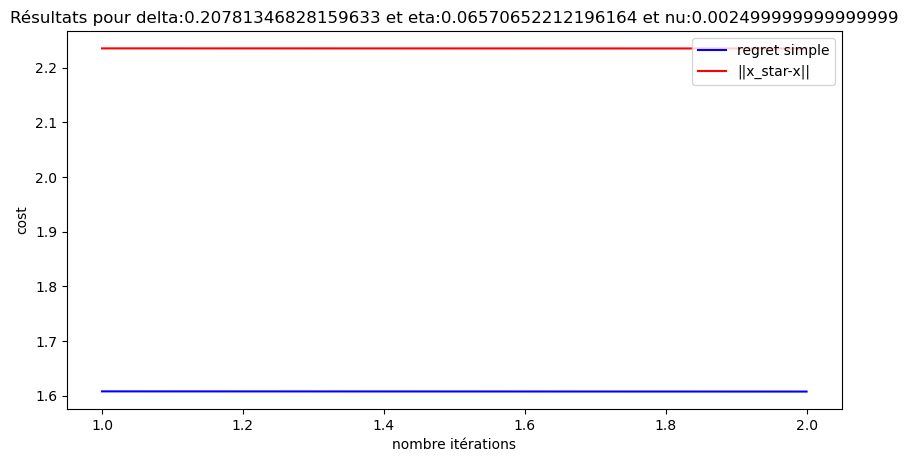

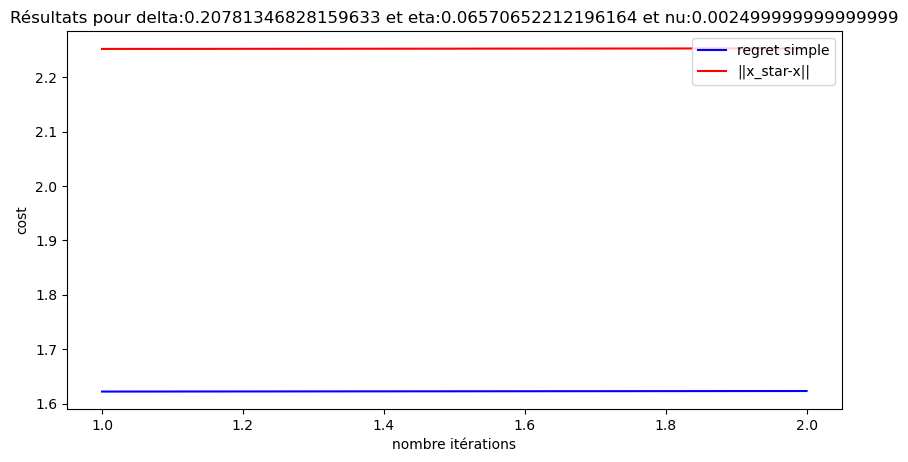

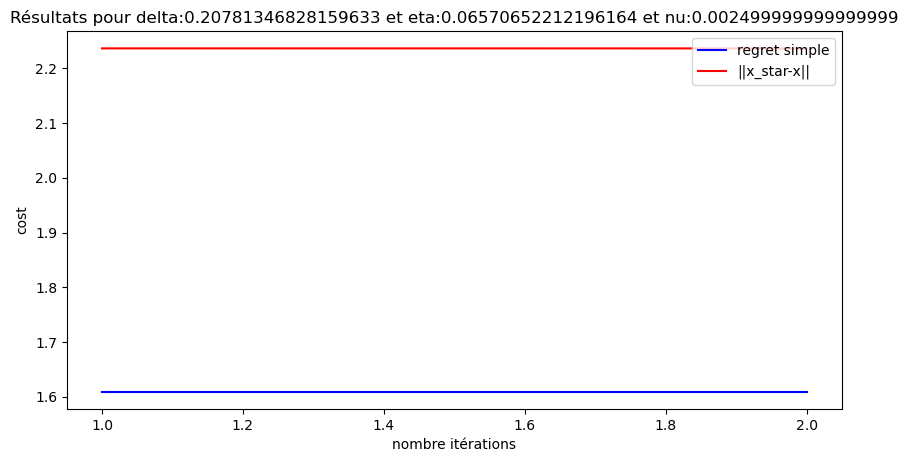

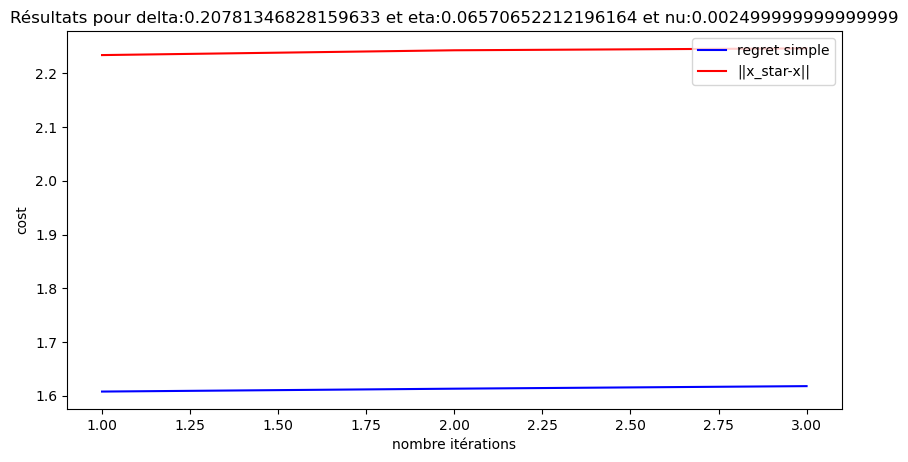

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


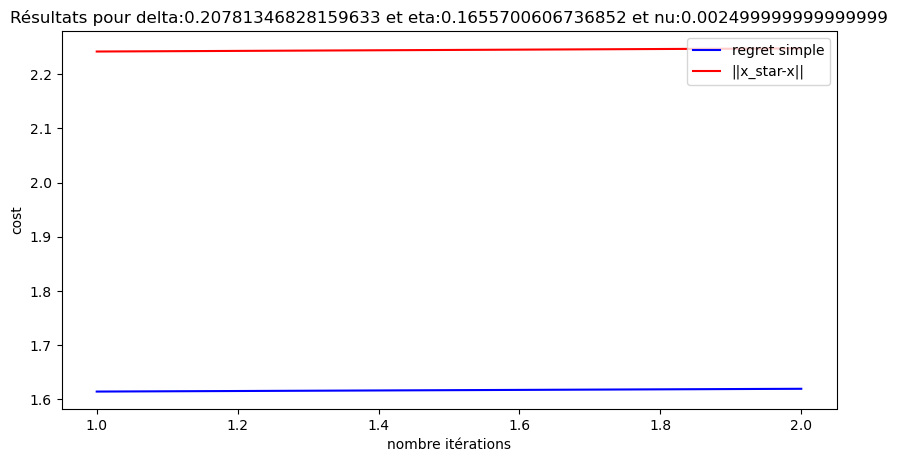

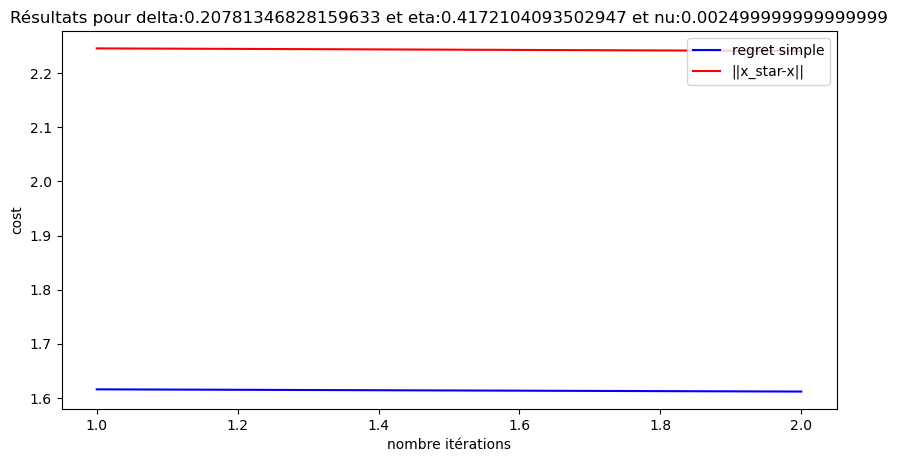

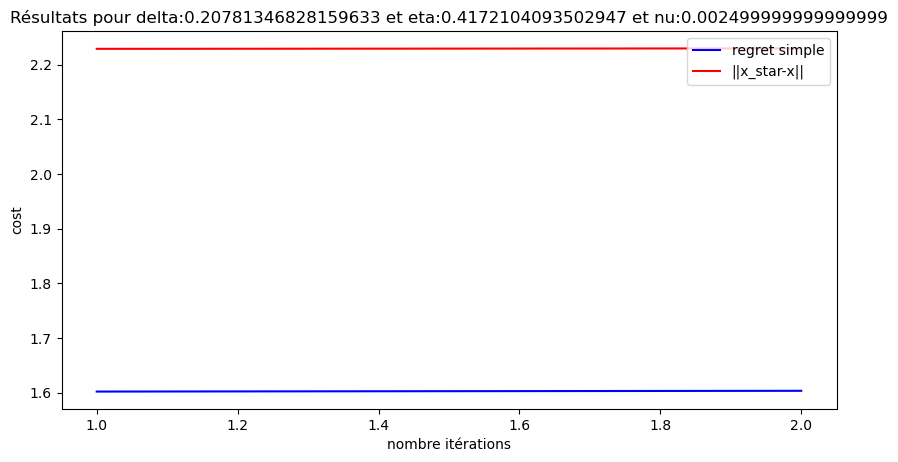

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


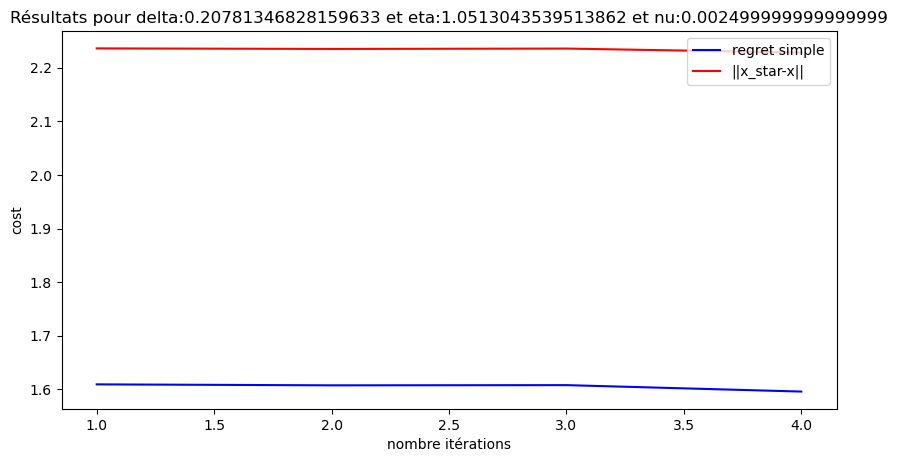

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


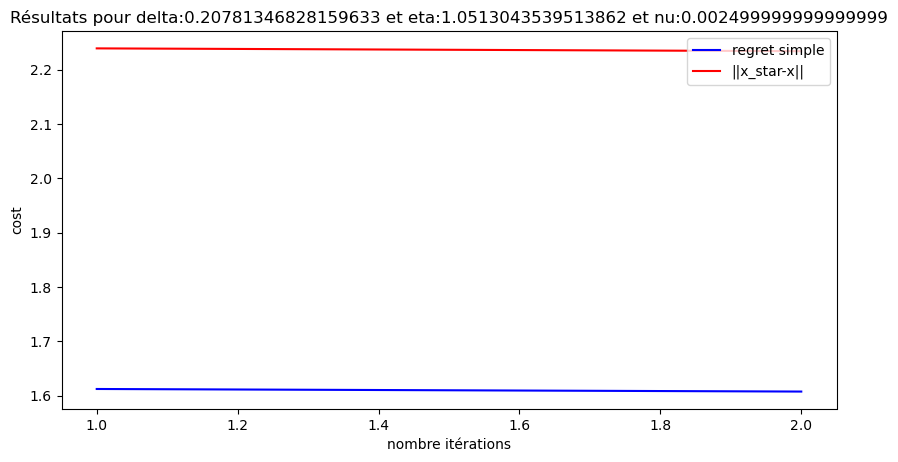

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


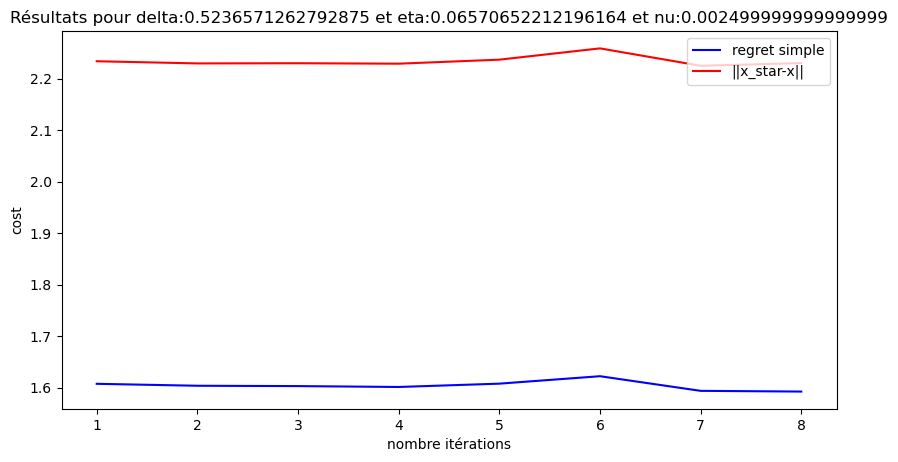

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


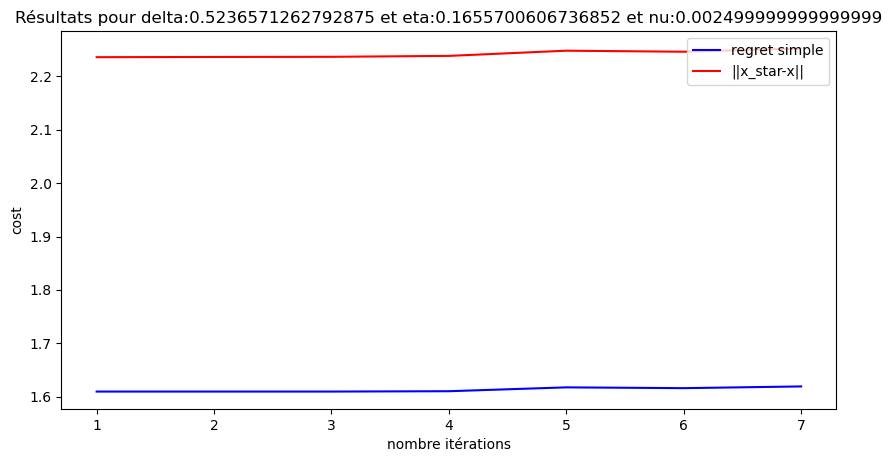

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


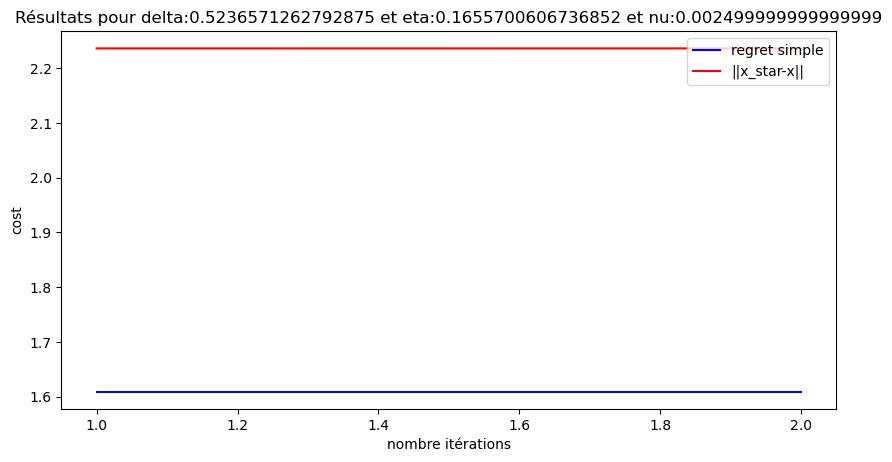

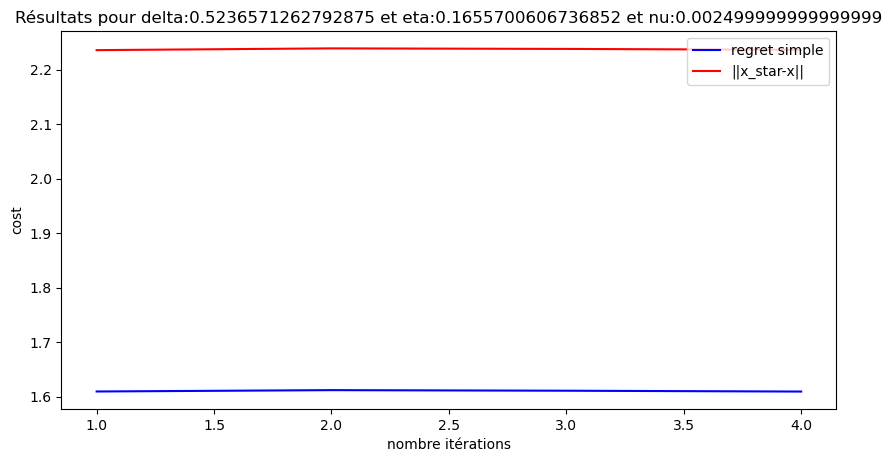

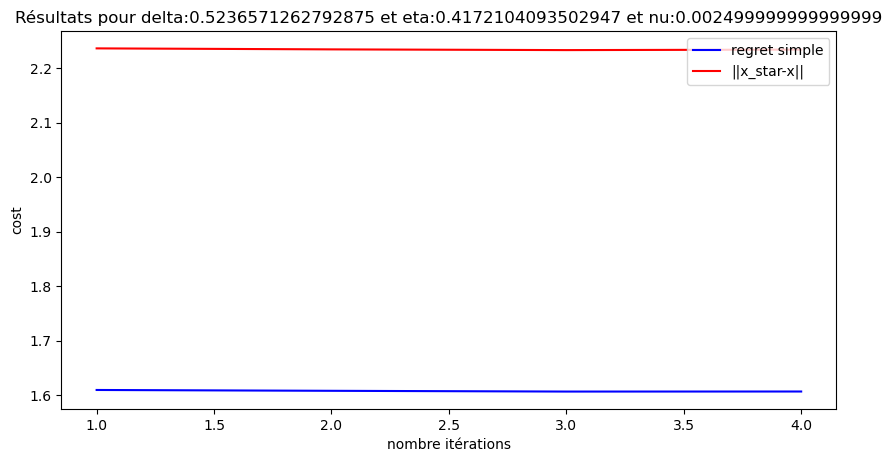

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


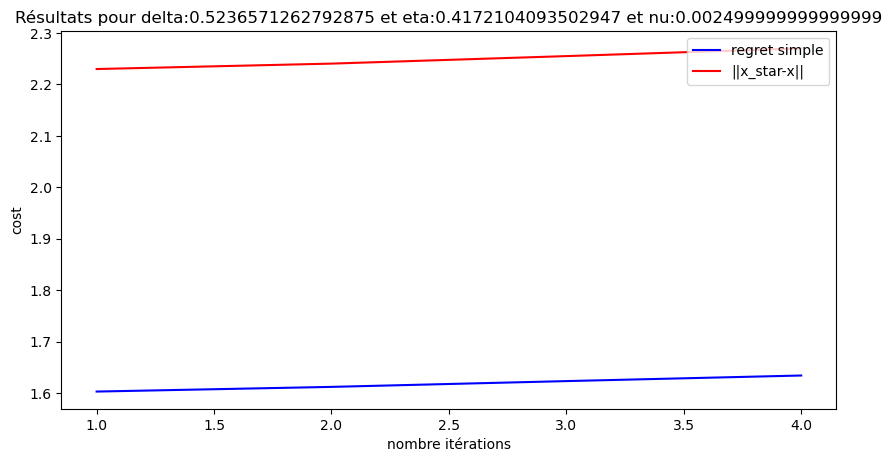

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


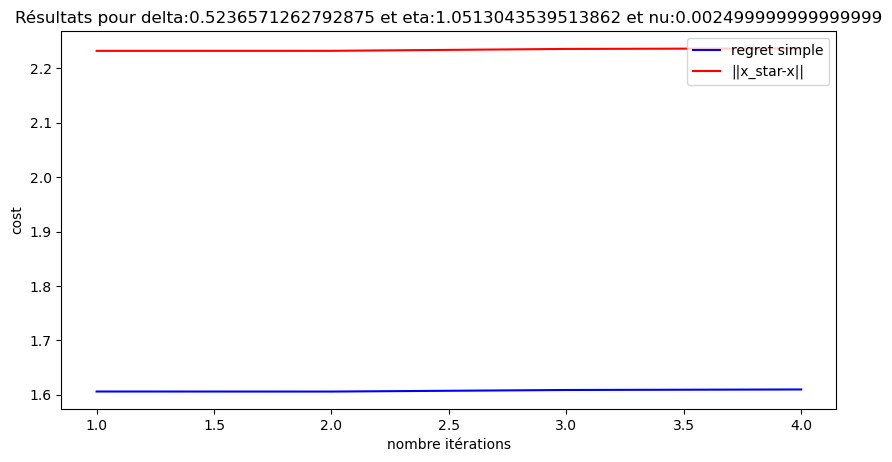

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


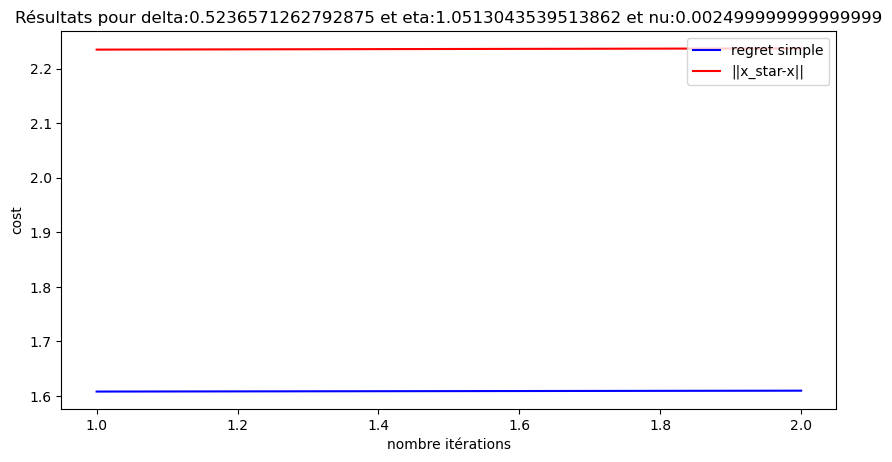

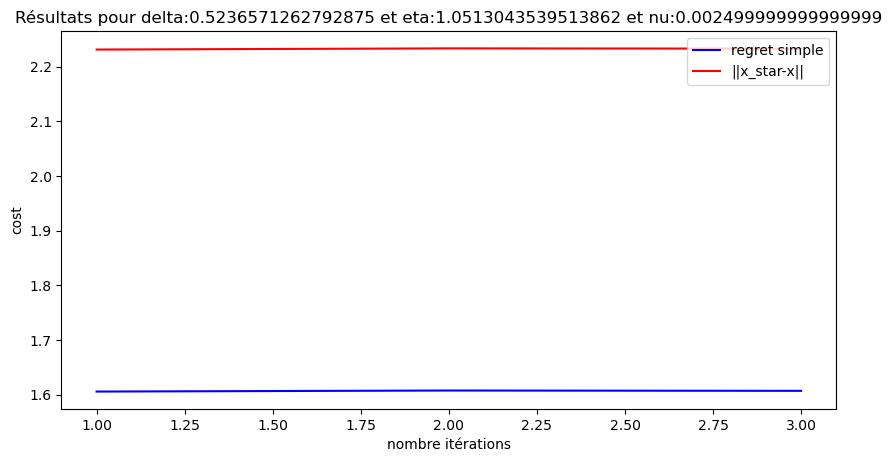

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_

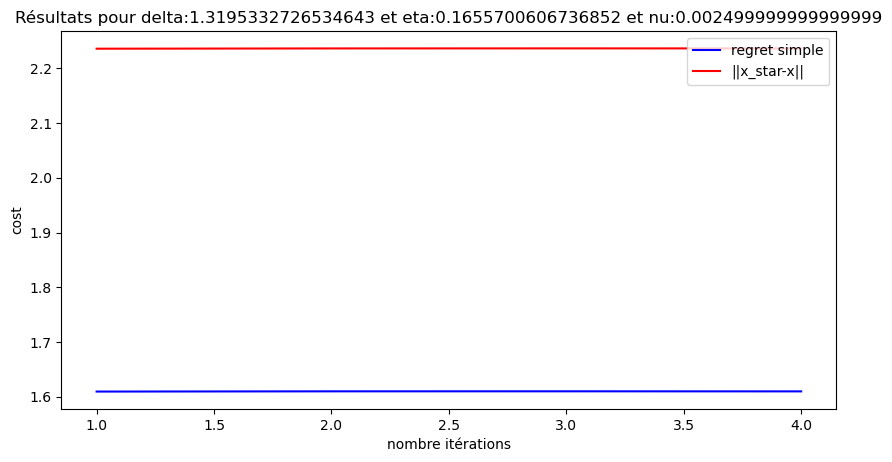

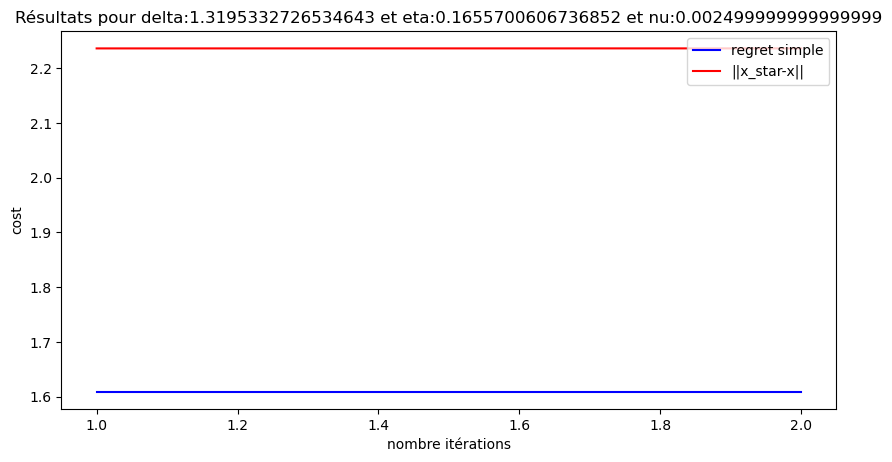

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


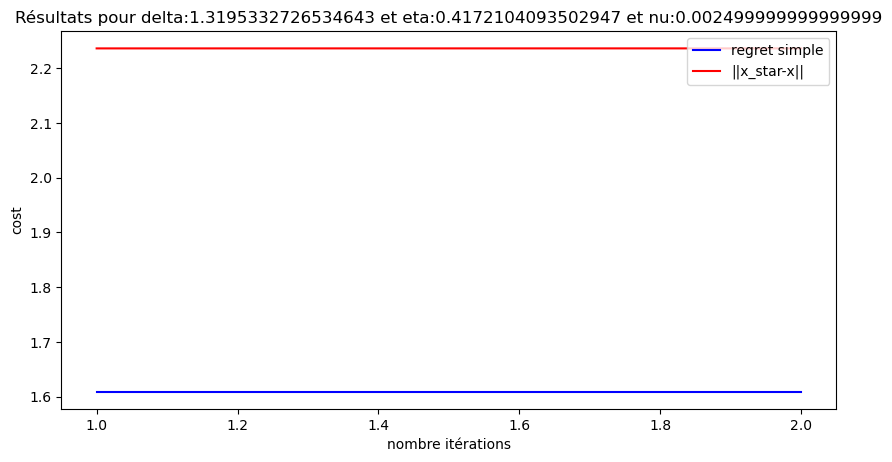

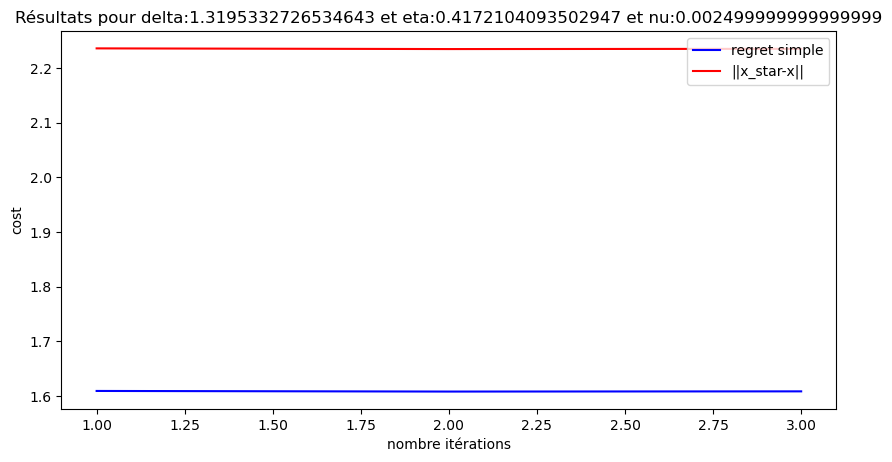

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_

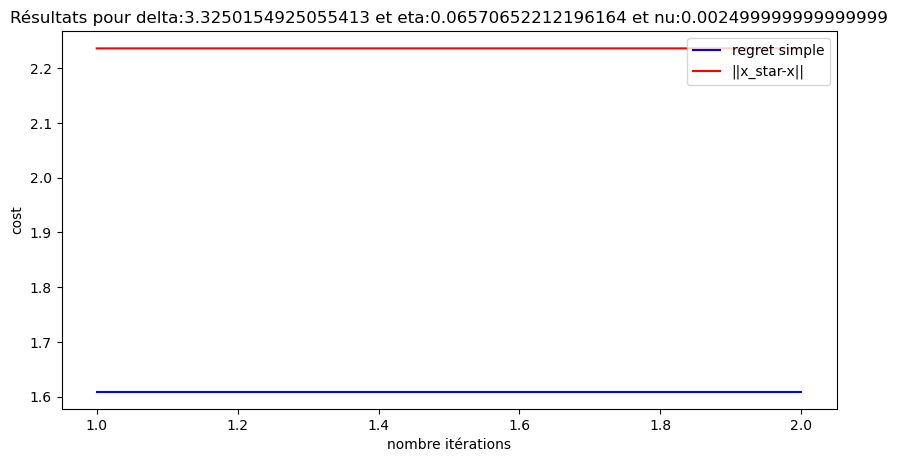

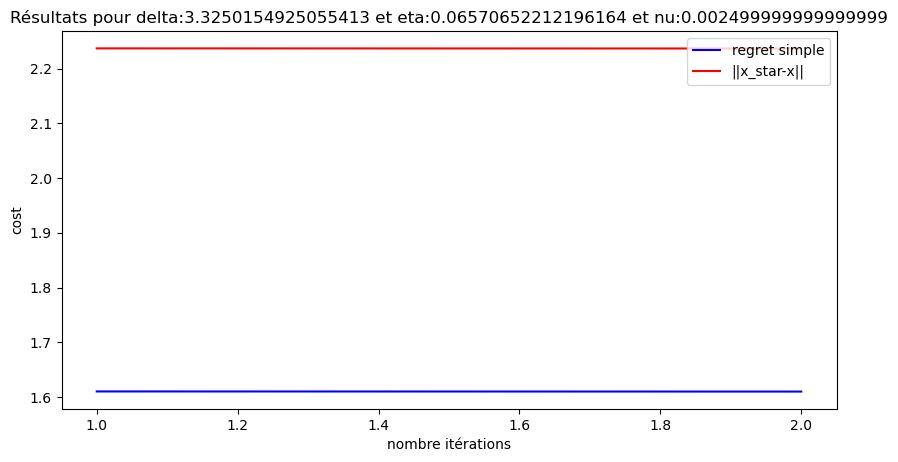

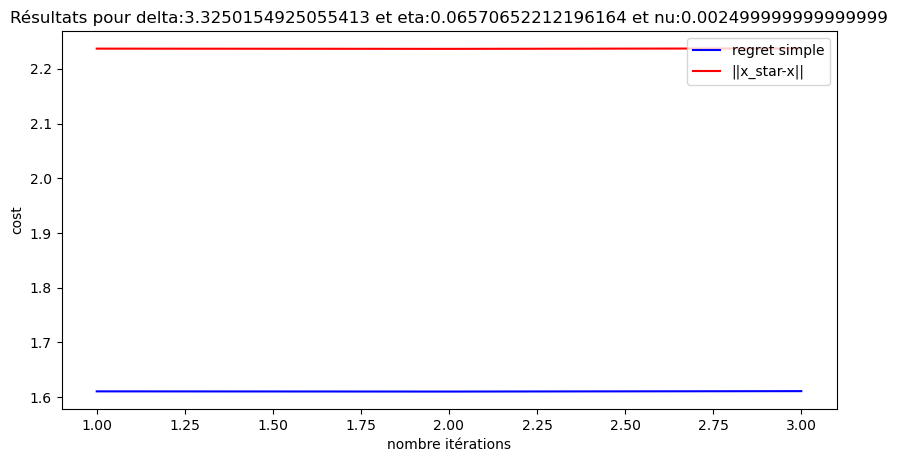

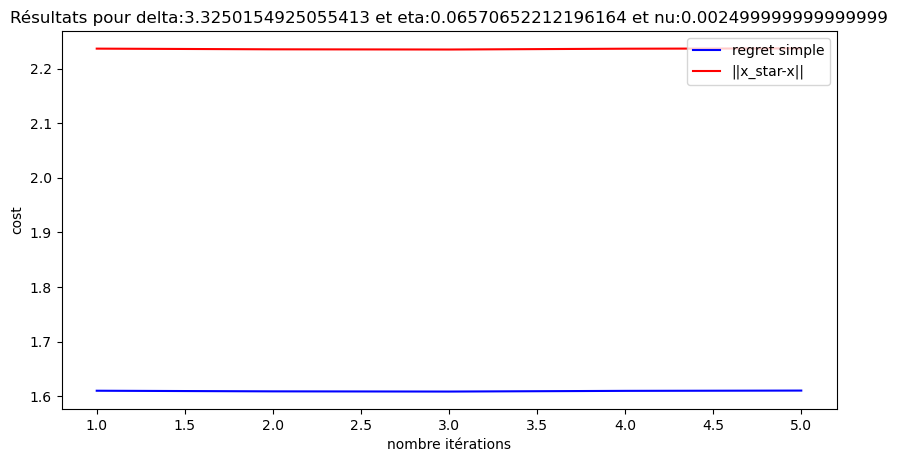

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


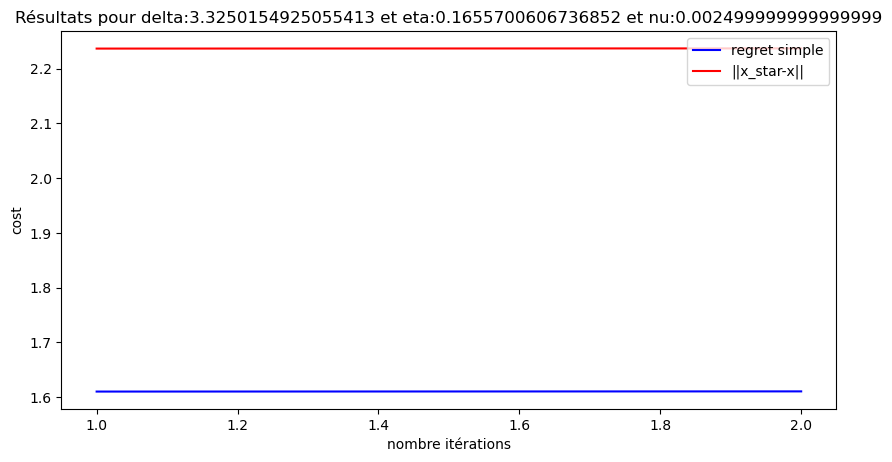

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


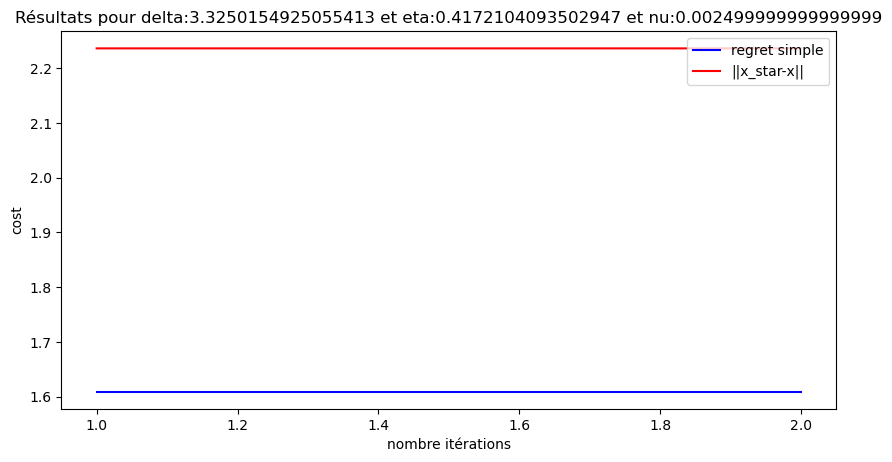

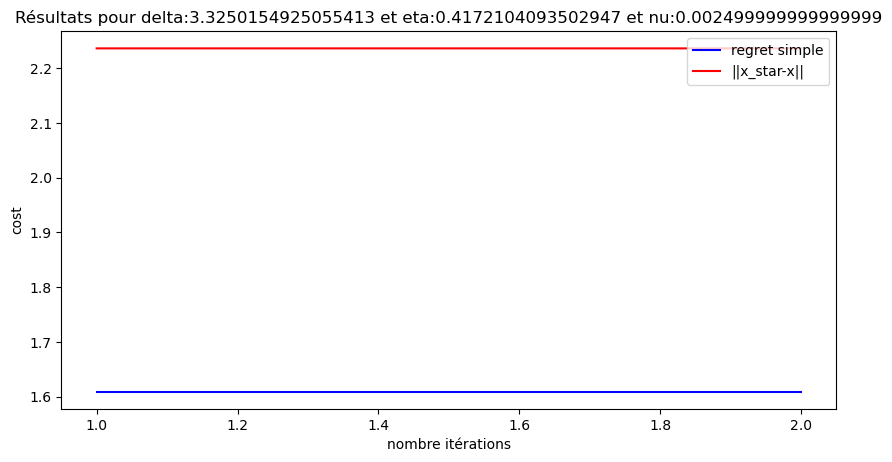

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


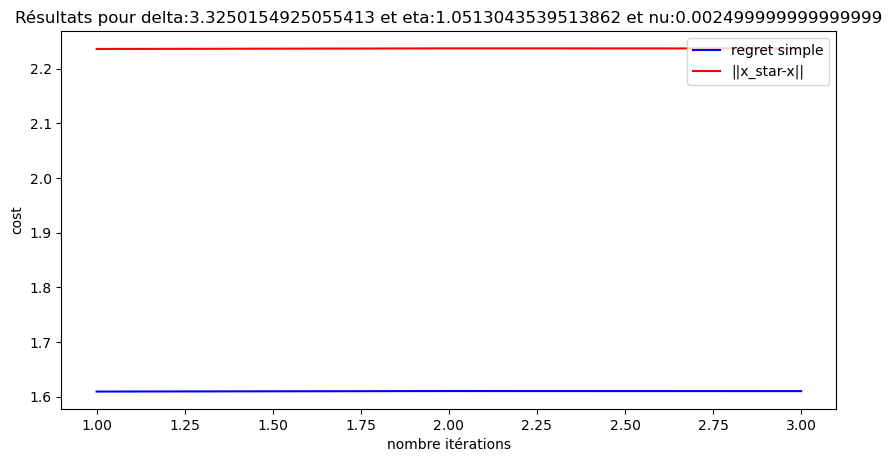

/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
/var/folders/ly/wpr5scy91hvfcf582r9f5zfh0000gn/T/ipykernel_47821/1483178194.py:4: UserWarning: Algorithm did not make any discovery
  x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)


In [253]:
for delta in log_grid_delta:
    for eta in log_grid_eta:
        for nu in log_grid_nu:
            x_t,simple_regret,cumulative_regret,x_cost=Successive_selection_algo(T=T,eta=eta,delta=delta,f=f_test_S,s=s,d=d,f_star=f_star,S=S,x_star=x_star,nu=nu)
            if len(simple_regret)!=0 and len(simple_regret)!=1 :
                plt.figure(figsize=(10, 5), dpi=100)
                plt.title(f"Résultats pour delta:{delta} et eta:{eta} et nu:{nu}")  # Titre du graphique
                plt.ylabel('cost')  # Titre de l'axe y
                plt.xlabel('nombre itérations')
                plt.plot(list(range(1,len(simple_regret)+1)),np.log(list(map(abs, simple_regret))),color='blue',label='log( simple regret)')
                plt.plot(list(range(1,len(x_cost)+1)), x_cost,color='red',label='||x_star-x||')
                plt.legend(loc='upper right')
                plt.show()

In [254]:
# Compute the grids for the hyperpameters of the  successive component selection algorithme
logarithmic_grid_eta_MD=log_grid_eta_miror_descent(B=B,d=d,T=T,n=n,nb_pnt=nb_pnt)
logarithmic_grid_dleta_MD=log_grid_delta_miror_descent(s=s,d=d,n=n,nb_pnt=nb_pnt)

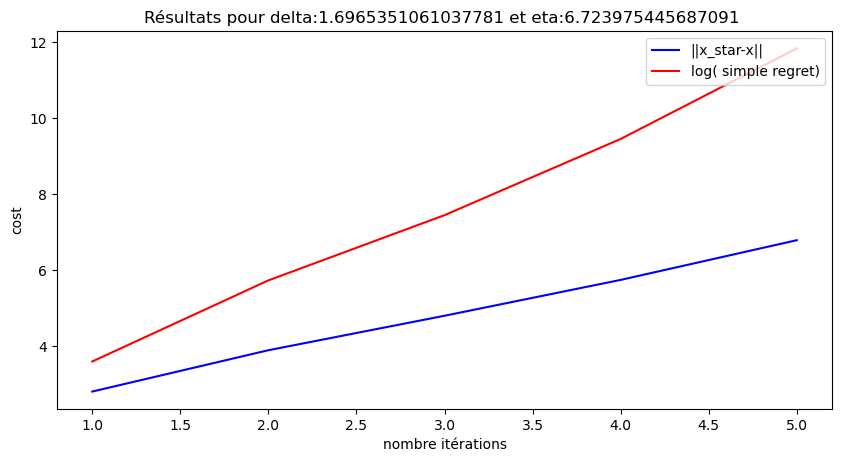

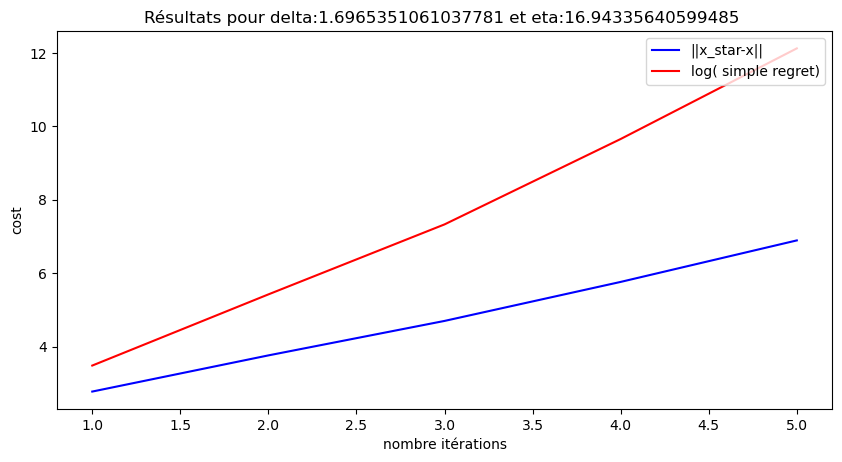

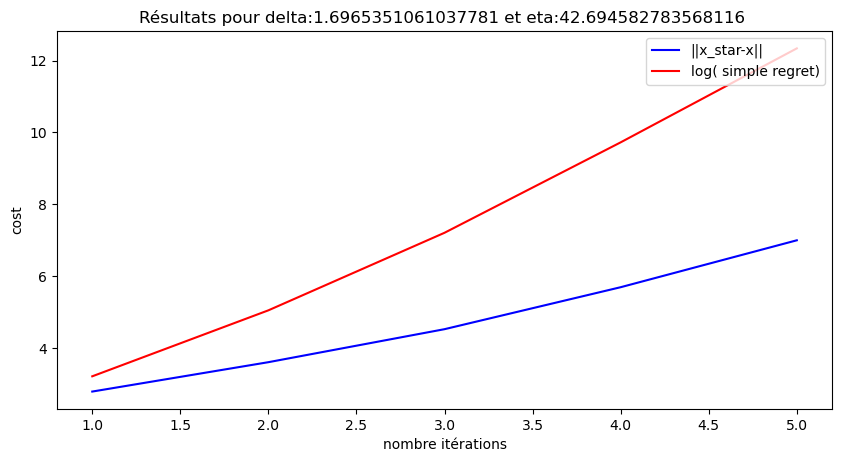

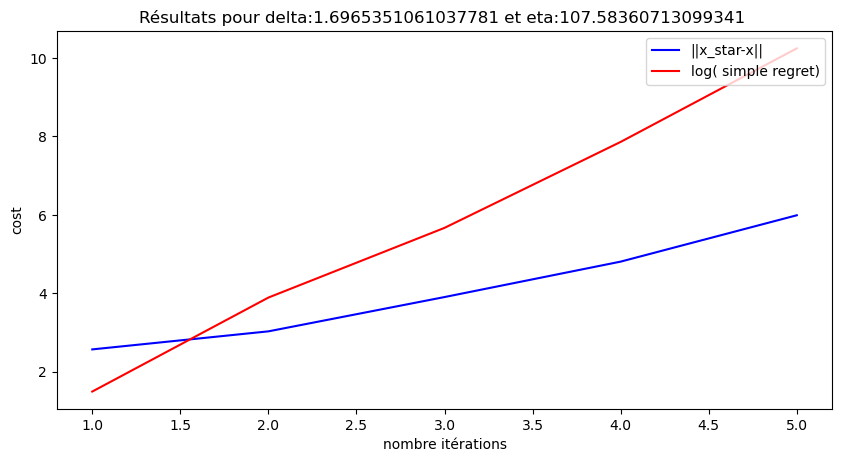

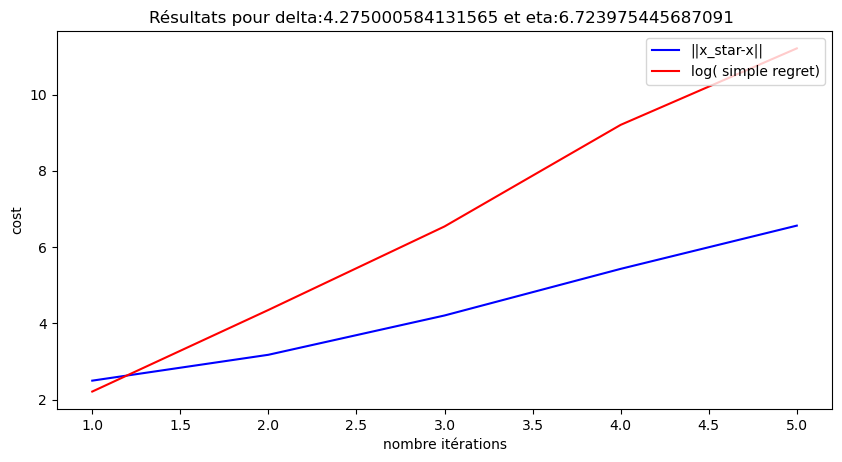

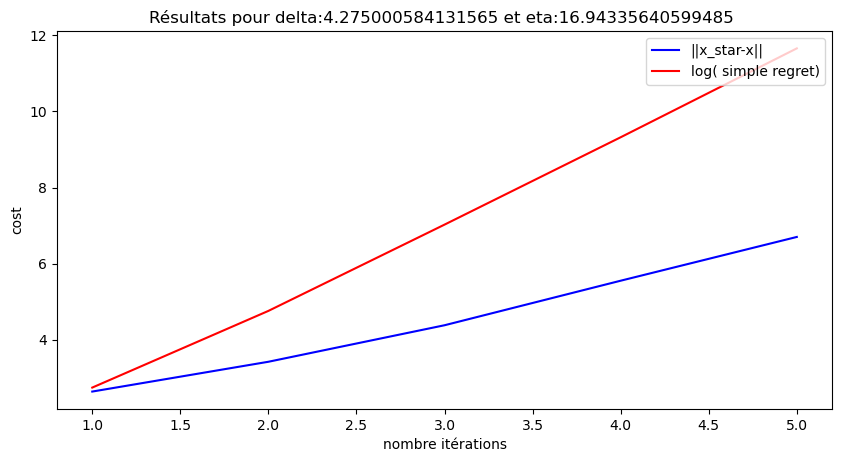

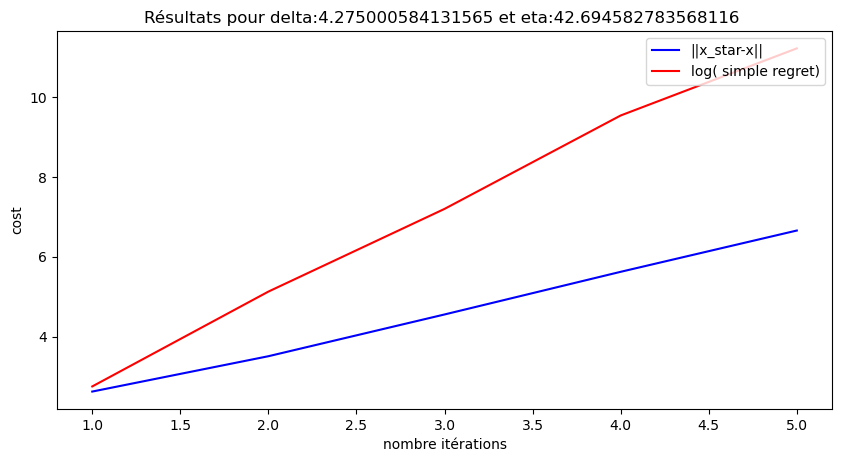

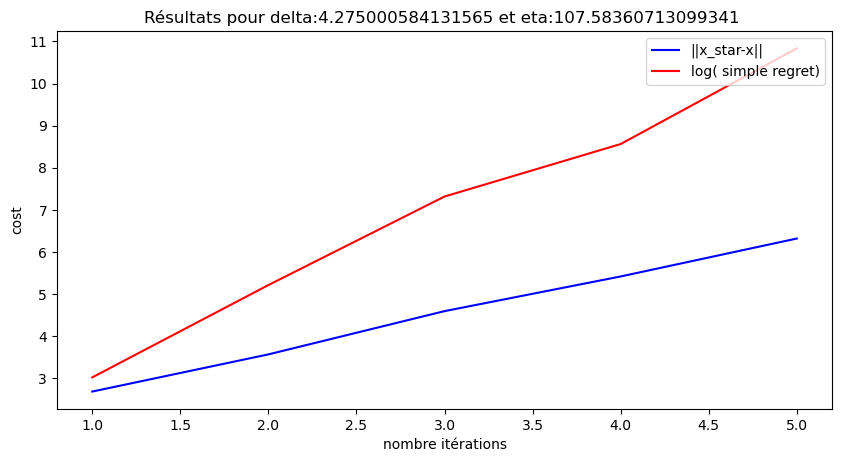

/Users/ilyeshammouda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.165e+02, tolerance: 9.782e+01
  model = cd_fast.enet_coordinate_descent(


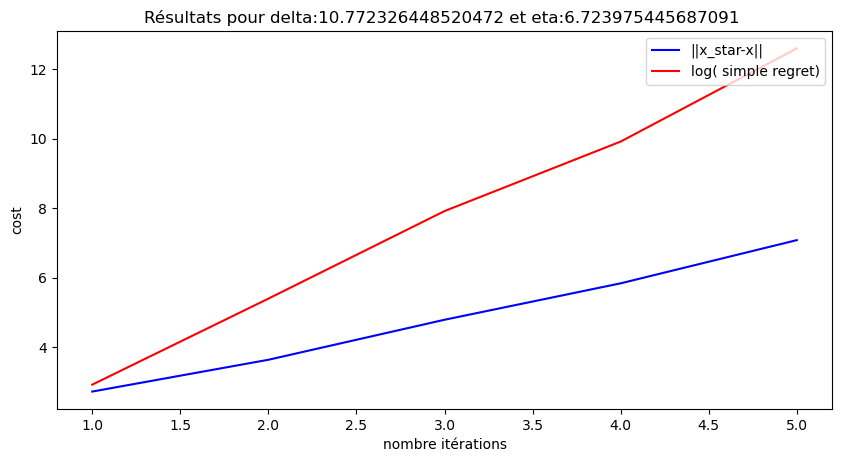

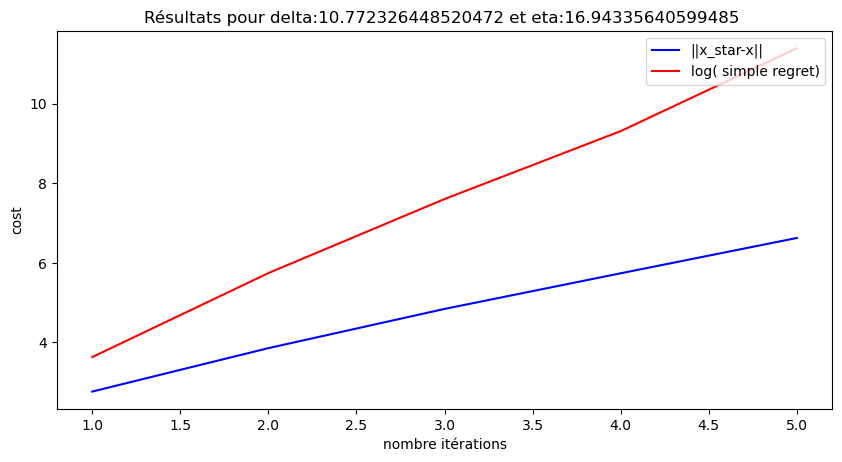

/Users/ilyeshammouda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e-01, tolerance: 2.254e-01
  model = cd_fast.enet_coordinate_descent(
/Users/ilyeshammouda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.049e+00, tolerance: 1.830e+00
  model = cd_fast.enet_coordinate_descent(


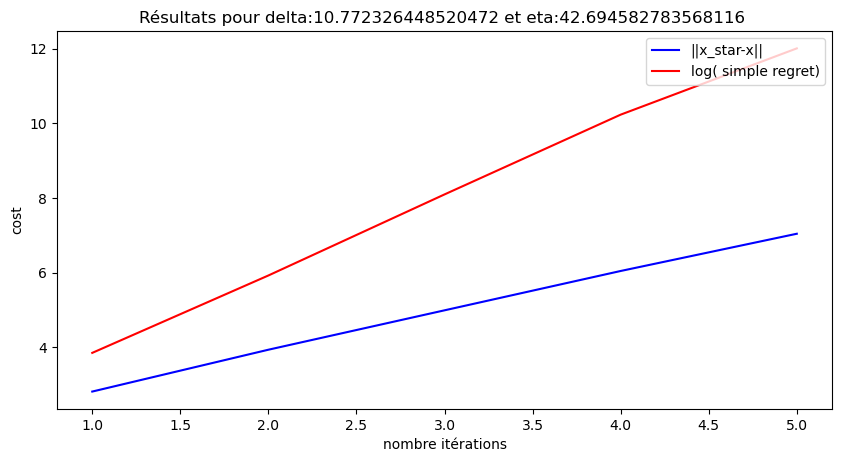

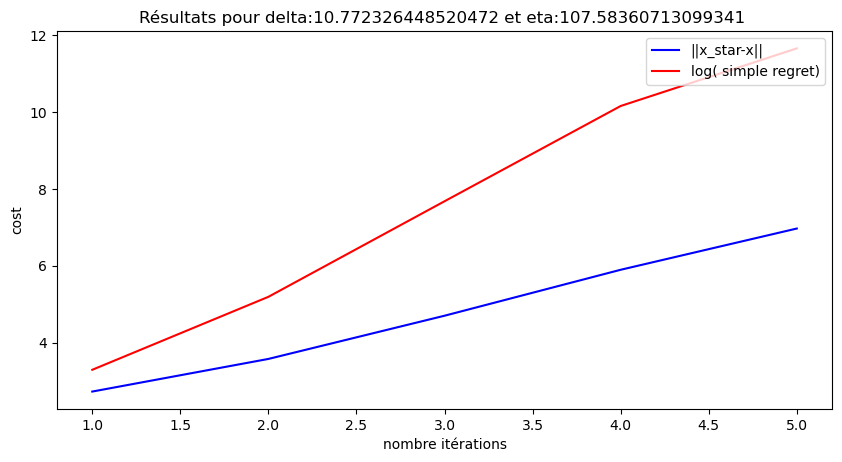

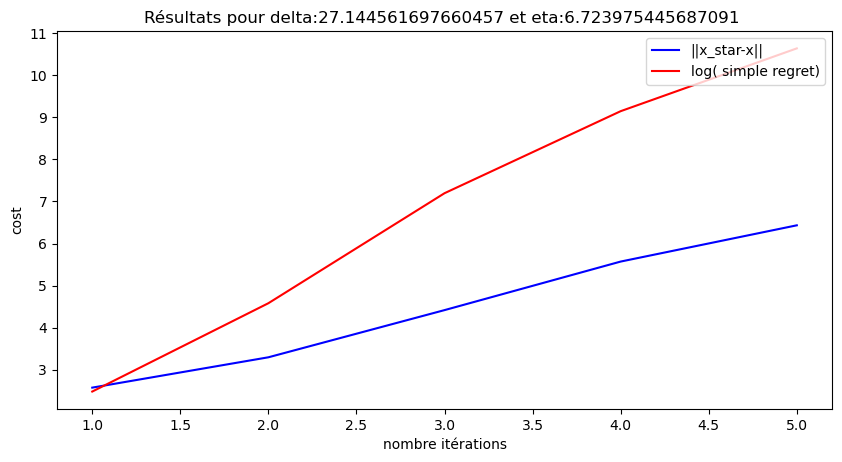

/Users/ilyeshammouda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.443e+01, tolerance: 8.557e+00
  model = cd_fast.enet_coordinate_descent(


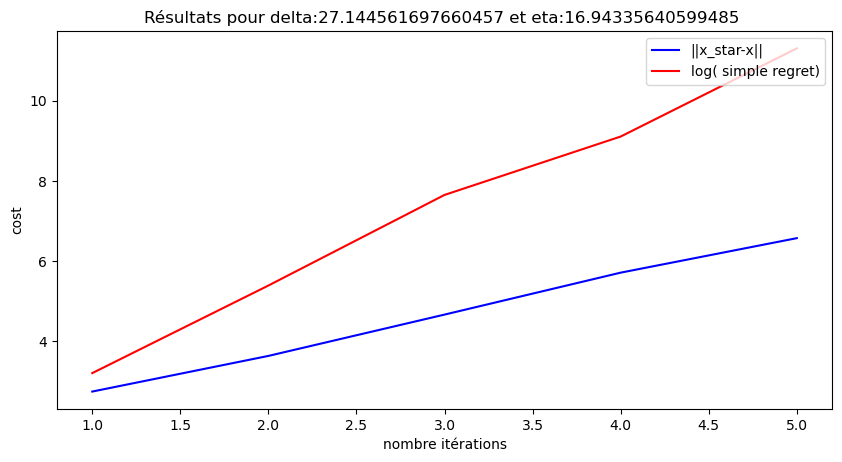

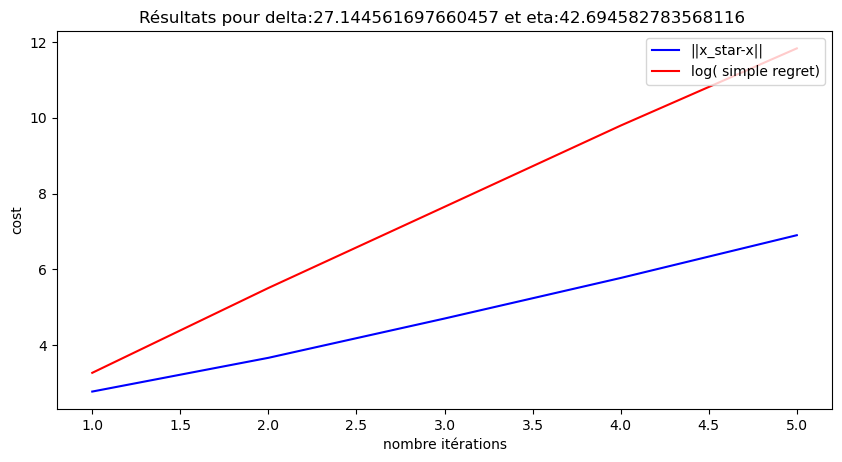

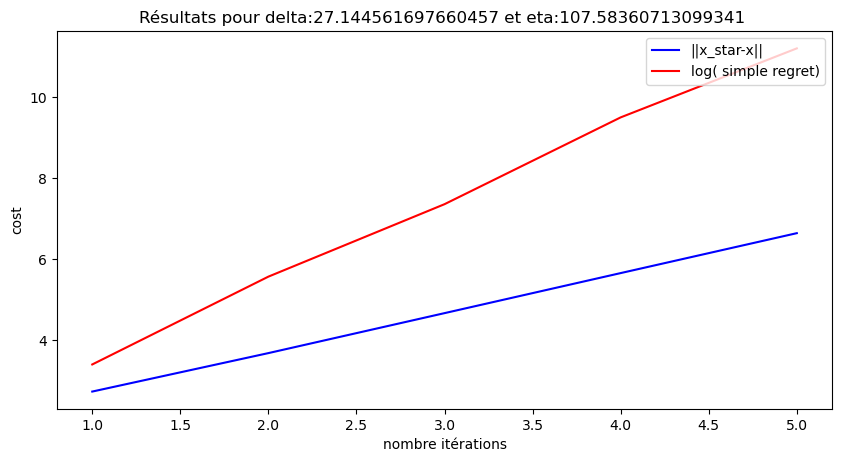

In [256]:
for delta in logarithmic_grid_dleta_MD:
    for eta in logarithmic_grid_eta_MD:
        x_t,simple_regret,cumulative_regret,x_cost,=First_order_optimization(B=B,T=T,n=n,d=d,psi=psi,eta=eta,delta=delta,S=S,f=f_test_S,objectif_function=miror_descent_objectif_function_a_2,f_star=f_star,x_star=x_star,constraint=constraint)
        plt.figure(figsize=(10, 5), dpi=100)
        plt.title(f"Résultats pour delta:{delta} et eta:{eta} ")  # Titre du graphique
        plt.ylabel('cost')  # Titre de l'axe y
        plt.xlabel('nombre itérations')
        plt.plot(list(range(1,len(x_cost)+1)),np.log(list(map(abs, x_cost))),color='blue',label='||x_star-x||')
        plt.plot(list(range(1,len(simple_regret)+1)),np.log(list(map(abs, simple_regret))),color='red',label='log( simple regret)')
        plt.legend(loc='upper right')
        plt.show()

In [ ]:
for delta in logarithmic_grid_dleta_MD:
    for eta in logarithmic_grid_eta_MD:
        x_t,simple_regret,cumulative_regret,x_cost,=First_order_optimization_modified(B=B,T=T,n=n,d=d,eta=eta,delta=delta,S=S,f=f_test_S,objectif_function=objective_lagragien,f_star=f_star,x_star=x_star)
        plt.figure(figsize=(10, 5), dpi=100)
        plt.title(f"Résultats pour delta:{delta} et eta:{eta} ")  # Titre du graphique
        plt.ylabel('cost')  # Titre de l'axe y
        plt.xlabel('nombre itérations')
        plt.plot(list(range(1,len(x_cost)+1)),np.log(list(map(abs, x_cost))),color='blue',label='||x_star-x||')
        plt.plot(list(range(1,len(cumulative_regret)+1)),np.log(list(map(abs, cumulative_regret))),color='red',label='regret cumulatif')
        plt.legend(loc='upper right')
        plt.show()